In [315]:

import pandas as pd
from rdkit import Chem
import re
from matplotlib import pyplot as plt
import numpy as np
from functools import partial

In [357]:
def atom_count(smi):
    atoms = [a for a in Chem.MolFromSmiles(smi).GetAtoms()]
    
    return len(atoms)

def remove_charges_func(reactant):
    # Regular expression to match charges (+, -, and numerical charges like +2, -3, etc.)
    charge_pattern = re.compile(r'(\d+)?[\+\-]')
    # Remove charges from the reactant string
    cleaned_reactant = re.sub(charge_pattern, '', reactant)
    # print(reactant, cleaned_reactant)
    return cleaned_reactant

def reconstruct_mol_from_atoms_and_bonds_only(old_mol, return_smi=False):
    # below handles the case of empty molecule smi read from the file => becomes np.nan in pandas dataframe
    #print(f'old_mol: {old_mol}, type: {pd.isna(old_mol)}\n')
    if pd.isna(old_mol): return '' if return_smi else None
    old_smi = '' # in case old_mol is given as None and we need to return SMILES
    if type(old_mol)==str: 
        old_smi = old_mol
        old_mol = Chem.MolFromSmiles(old_mol)
        
    if old_mol is None: return old_smi if return_smi else None
    
    # create atoms based on labels only
    atoms = [a.GetSymbol() for a in old_mol.GetAtoms()]
    bonds = [(b.GetBeginAtom().GetIdx(),b.GetEndAtom().GetIdx(),b.GetBondType()) for b in old_mol.GetBonds()]
    new_mol = Chem.RWMol()
    for a in atoms: new_mol.AddAtom(Chem.Atom(a))
    for beg_atom_idx, end_atom_idx, bond_type in bonds: new_mol.AddBond(beg_atom_idx, end_atom_idx, bond_type)
    
    if return_smi: return Chem.MolToSmiles(new_mol)
    
    return new_mol

def _assign_groups(df, samples_per_product):
    # group is the number of conditioning product
    # for test data: group is [0,5006], with each 10 samples having the same index
    df['group'] = np.arange(len(df)) // samples_per_product
    
    return df

def assign_groups(df, samples_per_product_per_file=10):
    # what does partial do here?
    # it's a way to fix a function's arguments to a specific value
    # what happens if we group by from_file then by group?
    # for each file, we assign numbers 0...nb_product_in_subset to each group of 10 samples 
    # (i.e. assign the index of the product to each group of 10 samples)
    df = df.groupby('from_file', group_keys=False).apply(partial(_assign_groups, samples_per_product=samples_per_product_per_file))
    
    return df

def compute_confidence(df, group_key='product'):
    '''
        Taken from retrobridge and modified in the following ways:
            1. renamed the columns to avoid confusion with stuff we computed before
            2. removed the group_size computation as it's not used since we compute it already to normalize the counts
    
    '''
    
    # count the number of times a prediction is made for a given product/group => repetitions!!
    counts = df.groupby([group_key, 'pred'], group_keys=False).size().reset_index(name='new_counts') 
    # group = single product => count the number of predictions we get per product => nb_samples_per_product
    # group_size = df.groupby([group_key], group_keys=False).size().reset_index(name='n_samples_per_product') # shld be 100 in paper experiments

    ## Don't use .merge() as it can change the order of rows
    # df = df.merge(counts, on=['group', 'pred'], how='left')
    # df = df.merge(counts, on=['group', 'pred'], how='inner')
    # df = df.merge(group_size, on=['group'], how='left')
    
    counts_dict = {(g, p): c for g, p, c in zip(counts[group_key], counts['pred'], counts['new_counts'])}
    df['new_counts'] = df.apply(lambda x: counts_dict[(x[group_key], x['pred'])], axis=1)

    # size_dict = {g: s for g, s in zip(group_size[group_key], group_size['n_samples_per_product'])}
    # df['n_samples_per_product'] = df.apply(lambda x: size_dict[x[group_key]], axis=1)

    # how many times the same prediction is made for a given product
    df['confidence'] = df['new_counts'] / df['n_samples_per_product']

    # sanity check
    # what does nunique do?
    # it counts the number of unique values in a series: all product_pred have the same confidence value
    # all groups have the same group_size (n_samples is the same for all products)
    assert (df.groupby([group_key, 'pred'], group_keys=False)['confidence'].nunique() == 1).all()
    assert (df.groupby([group_key], group_keys=False)['n_samples_per_product'].nunique() == 1).all()

    return df

def compute_confidence_like_rb(df):
    # count the number of times a prediction is made for a given product/group => repetitions!!
    counts = df.groupby(['group', 'pred'], group_keys=False).size().reset_index(name='count') 
    # group = single product => count the number of predictions we get per product => nb_samples_per_product
    group_size = df.groupby(['group'], group_keys=False).size().reset_index(name='group_size') # shld be 100 in paper experiments

    #     # Don't use .merge() as it can change the order of rows
    ##     df = df.merge(counts, on=['group', 'pred'], how='left')
    #     df = df.merge(counts, on=['group', 'pred'], how='inner')
    #     df = df.merge(group_size, on=['group'], how='left')
    
    counts_dict = {(g, p): c for g, p, c in zip(counts['group'], counts['pred'], counts['count'])}
    df['count'] = df.apply(lambda x: counts_dict[(x['group'], x['pred'])], axis=1)

    size_dict = {g: s for g, s in zip(group_size['group'], group_size['group_size'])}
    df['group_size'] = df.apply(lambda x: size_dict[x['group']], axis=1)

    # how many times the same prediction is made for a given product
    df['confidence'] = df['count'] / df['group_size']

    # sanity check
    # what does nunique do?
    # it counts the number of unique values in a series: all product_pred have the same confidence value
    # all groups have the same group_size (n_samples is the same for all products)
    assert (df.groupby(['group', 'pred'], group_keys=False)['confidence'].nunique() == 1).all()
    assert (df.groupby(['group'], group_keys=False)['group_size'].nunique() == 1).all()

    return df

In [208]:
common_samples_from_rb_path = '/Users/laabidn1/MolecularTransformer/data/rb_vs_7ck620/samples_from_rb_in_common.csv'
common_samples_from_7ck620_path = '/Users/laabidn1/MolecularTransformer/data/rb_vs_7ck620/samples_from_7ck620_in_common.csv'
samples_from_rb_path = '/Users/laabidn1/MolecularTransformer/data/retrobridge/retrobridge_samples.csv'

In [187]:
samples_from_7ck620_path = '/Users/laabidn1/MolecularTransformer/data/rb_vs_7ck620/samples_from_7ck620_no_proc.csv'

# Grouping by group vs product

Group considers the 7 duplicated products to be unique: i.e. it assigns different group indices to each product. This affects the results a little bit (see first example in `notes-on-results.md`). It seems like the fact that the two groups represent different seed results in considerably different samples (see cells below). Which in practice means more products => more chances for errors => lower accuracy/coverage metrics (but only slightly).

In [300]:
samples_from_rb_path = '/Users/laabidn1/MolecularTransformer/data/retrobridge/retrobridge_samples.csv'
rb_df = pd.read_csv(samples_from_rb_path)
rb_df['from_file'].unique()

array(['epoch=779_top_5_accuracy=0.758_T=500_n=10_seed=0.csv',
       'epoch=779_top_5_accuracy=0.758_T=500_n=10_seed=1.csv',
       'epoch=779_top_5_accuracy=0.758_T=500_n=10_seed=10.csv',
       'epoch=779_top_5_accuracy=0.758_T=500_n=10_seed=2.csv',
       'epoch=779_top_5_accuracy=0.758_T=500_n=10_seed=4.csv',
       'epoch=779_top_5_accuracy=0.758_T=500_n=10_seed=5.csv',
       'epoch=779_top_5_accuracy=0.758_T=500_n=10_seed=6.csv',
       'epoch=779_top_5_accuracy=0.758_T=500_n=10_seed=7.csv',
       'epoch=779_top_5_accuracy=0.758_T=500_n=10_seed=8.csv',
       'epoch=779_top_5_accuracy=0.758_T=500_n=10_seed=9.csv'],
      dtype=object)

In [304]:
rb_df.groupby('from_file').agg({'product':'nunique','pred':'nunique'})

,product,pred
from_file,,
epoch=779_top_5_accuracy=0.758_T=500_n=10_seed=0.csv,4938,50070
epoch=779_top_5_accuracy=0.758_T=500_n=10_seed=1.csv,4938,50070
epoch=779_top_5_accuracy=0.758_T=500_n=10_seed=10.csv,4938,50070
epoch=779_top_5_accuracy=0.758_T=500_n=10_seed=2.csv,4938,50070
epoch=779_top_5_accuracy=0.758_T=500_n=10_seed=4.csv,4938,50070
epoch=779_top_5_accuracy=0.758_T=500_n=10_seed=5.csv,4938,50070
epoch=779_top_5_accuracy=0.758_T=500_n=10_seed=6.csv,4938,50070
epoch=779_top_5_accuracy=0.758_T=500_n=10_seed=7.csv,4938,50070
epoch=779_top_5_accuracy=0.758_T=500_n=10_seed=8.csv,4938,50070


In [308]:
# 10 samples per file for each product, 20 comes from duplicated products
rb_df[rb_df['product']!='C'].groupby(['from_file', 'product']).size().unique()

array([10, 20])

In [310]:
rb_df.groupby(['from_file']).size().unique()

array([50070])

In [311]:
rb_df.shape

(500700, 10)

In [316]:
rb_df = assign_groups(rb_df, samples_per_product_per_file=10)

In [339]:
rb_df['group'].nunique()

5007

In [354]:
nb_products_with_one_group = rb_df.groupby('product').agg({'group':'nunique'}).query('group==1').shape[0]
nb_products_with_extra_group = rb_df.groupby('product').agg({'group':'nunique'}).query('group==2').shape[0]
placeholder = rb_df.groupby('product').agg({'group':'nunique'}).query('product=="C"').group.values[0]
nb_products_with_one_group+2*nb_products_with_extra_group+placeholder

5007

In [398]:
# the duplicated products in question
rb_df.groupby('product').agg({'group':'nunique'}).query('group==2')

,group
product,
CC(C)(C)OC(=O)C=C1CCCN(C(=O)OC(C)(C)C)C1,2
CC(C)(C)OC(=O)N1CCC(CO)CC1,2
CC(C)(C)OC(=O)N1CCN(C(=O)OC(C)(C)C)C(CO)C1,2
CCOC(=O)C(C)=CC(C(C)C)N(C)C(=O)C(NC(=O)C(NC)C(C)(C)c1cccs1)C(C)(C)C,2
N#CCc1ccc(Br)cc1F,2
O=C(O)CCCCCc1cccc2cncn12,2
O=N(O)c1cnnc1-c1nc2ccc(CN3CCOCC3)cc2n1,2


In [401]:
rb_df[rb_df['product']=='CC(C)(C)OC(=O)C=C1CCCN(C(=O)OC(C)(C)C)C1'].groupby('group').agg({'pred':'nunique'})

,pred
group,
1771,46
1772,47


In [406]:
pred_from_group1 = rb_df[(rb_df['product']=='CC(C)(C)OC(=O)C=C1CCCN(C(=O)OC(C)(C)C)C1')&(rb_df['group']==1771)]['pred']
pred_from_group2 = rb_df[(rb_df['product']=='CC(C)(C)OC(=O)C=C1CCCN(C(=O)OC(C)(C)C)C1')&(rb_df['group']==1772)]['pred']

In [418]:
# NOTE: interesting: only 12 out of 46/47 samples are common between the two groups
len(set(pred_from_group1.unique()).intersection(set(pred_from_group2.unique())))

14

In [417]:
pred_from_group1.sort_values().unique()[:10]

array(['C.CC(C)(C)OC(=O)CP1(=O)OCCCO1.CC(C)(C)OC(=O)N1CCCC(=O)C1',
       'C.CC(C)(C)OC(=O)N1CCCC(=O)C1.CC1COP(=O)(CC(=O)OC(C)(C)C)O1',
       'C.CCO[PH](=O)(CC(=O)OC(C)(C)C)(OCC)C1CCCN(C(=O)OC(C)(C)C)C1.O',
       'C1CCNCC1.CC(=O)OC(C)(C)C.CC(C)OC(C)(=O)OC(=O)OC(C)(C)C',
       'C=C(C)(C)C(=O)(O)C=C1CCCN(C(=O)OC(C)(C)C)C1',
       'CC(C)(C)O.CC(C)(C)OC(=O)C=C1CCCN(C(=O)O)C1',
       'CC(C)(C)O.CC(C)(C)OC(=O)N1CCCC(=CC(=O)Cl)C1',
       'CC(C)(C)O.CC(C)(C)OC(=O)N1CCCC(=CC(=O)O)C1',
       'CC(C)(C)OC(=O)C=C1(=O)CCCNC1.CC(C)OC(O)OC(=O)OC(C)(C)C',
       'CC(C)(C)OC(=O)C=C1(=O=C(O)(OC(=O)OC(C)(C)C)OC(C)(C)C)CCCNC1'],
      dtype=object)

In [419]:
pred_from_group2.sort_values().unique()[:10]

array(['C.C=C1CCCNC1.CC(C)(C)OC=O.CCOP(=O)(O)CC(=O)OC(C)(C)C.O',
       'C.CC(C)(C)OC(=O)CP1(=O)OCCCO1.CC(C)(C)OC(=O)N1CCCC(=O)C1',
       'C.CC(C)(C)OC(=O)N1CCCC(=O)C1.CC1COP(=O)(CC(=O)OC(C)(C)C)O1',
       'CC(C)(C)O.CC(C)(C)OC(=O)C=C1CCCN(C(=O)OC(C)(C)C)C1',
       'CC(C)(C)O.CC(C)(C)OC(=O)N1CCCC(=CC(=O)O)C1',
       'CC(C)(C)O.COC(=O)C=C1CCCN(C(=O)OC(C)(C)C)C1',
       'CC(C)(C)OC(=O)C=C1(=O)CCCNC1.CC(C)(C)OC(=O)OC(=O)OC(C)(C)C',
       'CC(C)(C)OC(=O)C=C1(=OCc2ccccc2)CCCN(C(=O)OC(C)(C)C)C1',
       'CC(C)(C)OC(=O)C=C1CCCNC1.CC(C)(C)OC(=O)OC(=O)OC(C)(C)(C)C',
       'CC(C)(C)OC(=O)C=C1CCCNC1.CC(C)(C)OC(=O)OC(=O)OC(C)(C)C'],
      dtype=object)

In [359]:
all_sizes = rb_df.groupby('product').size().to_dict()
rb_df['n_samples_per_product'] = rb_df.apply(lambda x: all_sizes[x['product']], axis=1)
rb_df = compute_confidence_like_rb(rb_df)
rb_df = compute_confidence(rb_df,group_key='product')
rb_df['normalized_counts'] = rb_df['count']/rb_df['n_samples_per_product']

In [ ]:
grouped = samples_from_7ck620.groupby(['product']).agg({'true':'size'})['true']
grouped[grouped==200]

product
CC(C)(C)OC(=O)C=C1CCCN(C(=O)OC(C)(C)C)C1                                 200
CC(C)(C)OC(=O)N1CCN(C(=O)OC(C)(C)C)C(CO)C1                               200
CCOC(=O)C(C)=CC(C(C)C)N(C)C(=O)C(NC(=O)C(NC)C(C)(C)C1=CC=CS1)C(C)(C)C    200
O=C(O)CCCCCC1=CC=CC2=CN=CN21                                             200
Name: true, dtype: int64

In [361]:
(rb_df['normalized_counts']==rb_df['confidence']).all()

False

In [362]:
(rb_df['count']==rb_df['new_counts']).all()

False

In [391]:
rb_df[(rb_df['count']!=rb_df['new_counts'])\
    &(rb_df['product']=='CC(C)(C)OC(=O)C=C1CCCN(C(=O)OC(C)(C)C)C1')].groupby(['product','pred']).agg({'count':'sum'})

count
product                                  pred                                                     
CC(C)(C)OC(=O)C=C1CCCN(C(=O)OC(C)(C)C)C1 C.CC(C)(C)OC(=O)CP1(=O)OCCCO1.CC(C)(C)OC(=O)N1C...      2
                                         C.CC(C)(C)OC(=O)N1CCCC(=O)C1.CC1COP(=O)(CC(=O)O...      8
                                         CC(C)(C)O.CC(C)(C)OC(=O)N1CCCC(=CC(=O)O)C1              2
                                         CC(C)(C)OC(=O)C=C1CCCNC1.CC(C)(C)OC(=O)OC(=O)OC...    761
                                         CC(C)(C)OC(=O)N1CCCC(=O)C1.CC=O.CCO[PH](=O)CC(=...      2
                                         CC(C)(C)OC(=O)N1CCCC(=O)C1.CCCOP(=O)(CC(=O)OC(C...      2
                                         CC(C)(C)OC(=O)N1CCCC(=O)C1.CCOP(=O)(CC(=O)OC(C)...      2
                                         CC(C)(C)OC(=O)N1CCCC(=O)C1.CCOP(=O)(CC(=O)OC(C)...   1013
                                         CC(C)(C)OC(=O)N1CCCC(=O)C1.CCO[PH](=O)(O)(CC(=O...      5
                                         CC(C)(C)OC(=O)N1CCCC(=O)C1.CCO[PH](=O)(O)(CC(=O...      5
                                         CC(C)(C)OC(=O)N1CCCC(=O)C1.CCO[PH](O)(CC(=O)OC(...      2
                                         CC(C)(C)OC(=O)N1CCCC(=O)C1.CCO[PH]1(=O)(CC(=O)O...      2
                                         CC(C)(C)OC(=O)N1CCCC(=O)C1.COP(=O)(CC(=O)OC(C)(...    113
                                         CC.CCOP(=O)(CC(=O)OC(C)(C)C)O=C1CCCN(C(=O)OC(C)...      5

In [388]:
rb_df[(rb_df['count']!=rb_df['new_counts'])\
    &(rb_df['product']=='CC(C)(C)OC(=O)C=C1CCCN(C(=O)OC(C)(C)C)C1')].groupby(['product','pred']).agg({'count':'min'})

count
product                                  pred                                                     
CC(C)(C)OC(=O)C=C1CCCN(C(=O)OC(C)(C)C)C1 C.CC(C)(C)OC(=O)CP1(=O)OCCCO1.CC(C)(C)OC(=O)N1C...      1
                                         C.CC(C)(C)OC(=O)N1CCCC(=O)C1.CC1COP(=O)(CC(=O)O...      2
                                         CC(C)(C)O.CC(C)(C)OC(=O)N1CCCC(=CC(=O)O)C1              1
                                         CC(C)(C)OC(=O)C=C1CCCNC1.CC(C)(C)OC(=O)OC(=O)OC...     19
                                         CC(C)(C)OC(=O)N1CCCC(=O)C1.CC=O.CCO[PH](=O)CC(=...      1
                                         CC(C)(C)OC(=O)N1CCCC(=O)C1.CCCOP(=O)(CC(=O)OC(C...      1
                                         CC(C)(C)OC(=O)N1CCCC(=O)C1.CCOP(=O)(CC(=O)OC(C)...      1
                                         CC(C)(C)OC(=O)N1CCCC(=O)C1.CCOP(=O)(CC(=O)OC(C)...     22
                                         CC(C)(C)OC(=O)N1CCCC(=O)C1.CCO[PH](=O)(O)(CC(=O...      1
                                         CC(C)(C)OC(=O)N1CCCC(=O)C1.CCO[PH](=O)(O)(CC(=O...      1
                                         CC(C)(C)OC(=O)N1CCCC(=O)C1.CCO[PH](O)(CC(=O)OC(...      1
                                         CC(C)(C)OC(=O)N1CCCC(=O)C1.CCO[PH]1(=O)(CC(=O)O...      1
                                         CC(C)(C)OC(=O)N1CCCC(=O)C1.COP(=O)(CC(=O)OC(C)(...      7
                                         CC.CCOP(=O)(CC(=O)OC(C)(C)C)O=C1CCCN(C(=O)OC(C)...      1

In [390]:
rb_df[(rb_df['count']!=rb_df['new_counts'])\
    &(rb_df['product']=='CC(C)(C)OC(=O)C=C1CCCN(C(=O)OC(C)(C)C)C1')].groupby(['product','pred']).agg({'new_counts':'mean'})

new_counts
product                                  pred                                                          
CC(C)(C)OC(=O)C=C1CCCN(C(=O)OC(C)(C)C)C1 C.CC(C)(C)OC(=O)CP1(=O)OCCCO1.CC(C)(C)OC(=O)N1C...         2.0
                                         C.CC(C)(C)OC(=O)N1CCCC(=O)C1.CC1COP(=O)(CC(=O)O...         4.0
                                         CC(C)(C)O.CC(C)(C)OC(=O)N1CCCC(=CC(=O)O)C1                 2.0
                                         CC(C)(C)OC(=O)C=C1CCCNC1.CC(C)(C)OC(=O)OC(=O)OC...        39.0
                                         CC(C)(C)OC(=O)N1CCCC(=O)C1.CC=O.CCO[PH](=O)CC(=...         2.0
                                         CC(C)(C)OC(=O)N1CCCC(=O)C1.CCCOP(=O)(CC(=O)OC(C...         2.0
                                         CC(C)(C)OC(=O)N1CCCC(=O)C1.CCOP(=O)(CC(=O)OC(C)...         2.0
                                         CC(C)(C)OC(=O)N1CCCC(=O)C1.CCOP(=O)(CC(=O)OC(C)...        45.0
                                         CC(C)(C)OC(=O)N1CCCC(=O)C1.CCO[PH](=O)(O)(CC(=O...         3.0
                                         CC(C)(C)OC(=O)N1CCCC(=O)C1.CCO[PH](=O)(O)(CC(=O...         3.0
                                         CC(C)(C)OC(=O)N1CCCC(=O)C1.CCO[PH](O)(CC(=O)OC(...         2.0
                                         CC(C)(C)OC(=O)N1CCCC(=O)C1.CCO[PH]1(=O)(CC(=O)O...         2.0
                                         CC(C)(C)OC(=O)N1CCCC(=O)C1.COP(=O)(CC(=O)OC(C)(...        15.0
                                         CC.CCOP(=O)(CC(=O)OC(C)(C)C)O=C1CCCN(C(=O)OC(C)...         3.0

In [379]:
rb_df[rb_df['count']!=rb_df['new_counts']].groupby('product').agg({'group':'nunique'}).query('group>1').reset_index()['product'].sort_values().values

array(['C', 'CC(C)(C)OC(=O)C=C1CCCN(C(=O)OC(C)(C)C)C1',
       'CC(C)(C)OC(=O)N1CCC(CO)CC1',
       'CC(C)(C)OC(=O)N1CCN(C(=O)OC(C)(C)C)C(CO)C1',
       'CCOC(=O)C(C)=CC(C(C)C)N(C)C(=O)C(NC(=O)C(NC)C(C)(C)c1cccs1)C(C)(C)C',
       'N#CCc1ccc(Br)cc1F', 'O=C(O)CCCCCc1cccc2cncn12',
       'O=N(O)c1cnnc1-c1nc2ccc(CN3CCOCC3)cc2n1'], dtype=object)

In [392]:
all_sizes = rb_df.groupby('product').size().to_dict()
all_counts = rb_df.groupby(['product','pred']).size().to_dict()
rb_df['n_samples_per_product'] = rb_df.apply(lambda x: all_sizes[x['product']], axis=1)
rb_df['counts'] = rb_df.apply(lambda x: all_counts[x['product'],x['pred']], axis=1)
rb_df['normalized_counts'] = rb_df['counts']/rb_df['n_samples_per_product']


In [393]:
rb_df['n_samples_per_product'].unique()

array([ 100, 6300,  200])

In [395]:
rb_df['counts'].max()

1452

# Data loading

In [ ]:
samples_from_rb_in_common = pd.read_csv(common_samples_from_rb_path, index_col=0, delimiter=',')
samples_from_7ck620_in_common = pd.read_csv(common_samples_from_7ck620_path, index_col=0, delimiter=',')
# samples_from_7ck620 = pd.read_csv(samples_from_7ck620_path)

In [ ]:
# check that the products are indeed the same
# NOTE: dataframes contain a different number of samples, but the same number (and values) of products
assert (samples_from_7ck620_in_common.sort_values('product')['product'].unique()
    ==samples_from_rb_in_common.sort_values('product')['product'].unique()).all()
assert (samples_from_7ck620_in_common.sort_values('true')['true'].unique()
    ==samples_from_rb_in_common.sort_values('true')['true'].unique()).all()

In [ ]:
# 7ck620 has some pred that are 'nan': comes from empty smiles string when remapping with chython
# no need to remove these: keep so the shapes of the rb_common and 7ck620_common are the same, but ignore in later processing
samples_from_7ck620_in_common['pred'].isna().sum()

In [ ]:
# NOTE: this is really slow (~10 min per line). Run one line at a time
# TODO: anyway to make this faster?
#samples_from_7ck620_in_common['product'] = samples_from_7ck620_in_common['product'].apply(lambda x: reconstruct_mol_from_atoms_and_bonds_only(x,return_smi=True))
#samples_from_7ck620_in_common['pred'] = samples_from_7ck620_in_common['pred'].apply(lambda x: reconstruct_mol_from_atoms_and_bonds_only(x,return_smi=True))
#samples_from_7ck620_in_common['true'] = samples_from_7ck620_in_common['true'].apply(lambda x: reconstruct_mol_from_atoms_and_bonds_only(x,return_smi=True))
#samples_from_7ck620_in_common['pred_product'] = samples_from_7ck620_in_common['pred_product'].apply(lambda x: reconstruct_mol_from_atoms_and_bonds_only(x,return_smi=True))

In [ ]:
# quick sanity check: molecules rebuilt from atoms and bonds should not contain any stereochemistry information
# kind of a weak check atm
assert samples_from_7ck620_in_common['pred'].str.contains('@').sum()==0
assert samples_from_7ck620_in_common['product'].str.contains('@').sum()==0
assert samples_from_7ck620_in_common['true'].str.contains('@').sum()==0
assert samples_from_7ck620_in_common['pred_product'].str.contains('@').sum()==0

In [ ]:
# save the post-processed 7ck620 samples from atoms and bonds to csv
# samples_from_7ck620_in_common.to_csv('/Users/laabidn1/MolecularTransformer/data/rb_vs_7ck620/samples_from_7ck620_in_common_all_from_atoms.csv')

In [ ]:
samples_from_7ck620_in_common['round_trip'] = (samples_from_7ck620_in_common['product']==samples_from_7ck620_in_common['pred_product'])
samples_from_7ck620_in_common['exact_match'] = (samples_from_7ck620_in_common['pred']==samples_from_7ck620_in_common['true'])
samples_from_7ck620_in_common['match'] = samples_from_7ck620_in_common['round_trip'] | samples_from_7ck620_in_common['exact_match']

samples_from_rb_in_common['round_trip'] = (samples_from_rb_in_common['product']==samples_from_rb_in_common['pred_product'])
samples_from_rb_in_common['exact_match'] = (samples_from_rb_in_common['pred']==samples_from_rb_in_common['true'])
samples_from_rb_in_common['match'] = samples_from_rb_in_common['round_trip'] | samples_from_rb_in_common['exact_match']

# Compare total # of correct round_trip

In [289]:
dedup_samples_from_rb_in_common = samples_from_rb_in_common.drop_duplicates(subset=['product','pred','true'])
dedup_samples_from_7ck620_in_common = samples_from_7ck620_in_common.drop_duplicates(subset=['product','pred','true'])

In [293]:
dedup_samples_from_rb_in_common.shape

(77469, 13)

In [297]:
dedup_samples_from_7ck620_in_common.shape

32537

In [ ]:
dedup_samples_from_7ck620_in_common.shape[0]-dedup_samples_from_rb_in_common.shape[0]

In [295]:
dedup_samples_from_rb_in_common['round_trip'].sum()-dedup_samples_from_7ck620_in_common['round_trip'].sum()

430

In [292]:
dedup_samples_from_7ck620_in_common['round_trip'].sum()

38522

# Check the number of samples per product

In [188]:
# we have duplicate reactions in the dataset
# rb has one extra reaction duplicated compared to 7ck620, in common samples??
samples_from_7ck620 = pd.read_csv(samples_from_7ck620_path)
samples_from_7ck620[samples_from_7ck620['product']!='C'].groupby('product').agg({'pred':"size"})['pred'].unique()

n_preds_per_product_7ck620 = samples_from_7ck620.groupby(['product']).agg({'pred':'size'})['pred']
n_preds_per_product_7ck620[n_preds_per_product_7ck620==200]


product
CC(C)(C)OC(=O)C=C1CCCN(C(=O)OC(C)(C)C)C1                                 200
CC(C)(C)OC(=O)N1CCN(C(=O)OC(C)(C)C)C(CO)C1                               200
CCOC(=O)C(C)=CC(C(C)C)N(C)C(=O)C(NC(=O)C(NC)C(C)(C)C1=CC=CS1)C(C)(C)C    200
O=C(O)CCCCCC1=CC=CC2=CN=CN21                                             200
Name: pred, dtype: int64

In [197]:
grouped = samples_from_7ck620.groupby(['product']).agg({'true':'size'})['true']
grouped[grouped==200]

product
CC(C)(C)OC(=O)C=C1CCCN(C(=O)OC(C)(C)C)C1                                 200
CC(C)(C)OC(=O)N1CCN(C(=O)OC(C)(C)C)C(CO)C1                               200
CCOC(=O)C(C)=CC(C(C)C)N(C)C(=O)C(NC(=O)C(NC)C(C)(C)C1=CC=CS1)C(C)(C)C    200
O=C(O)CCCCCC1=CC=CC2=CN=CN21                                             200
Name: true, dtype: int64

In [204]:
samples_from_7ck620[samples_from_7ck620['product']=='CC(C)(C)OC(=O)N1CCN(C(=O)OC(C)(C)C)C(CO)C1']['true'].unique()

array(['CC(C)(C)OC(=O)N1CCN(C(=O)OC(C)(C)C)C(C(=O)O)C1'], dtype=object)

In [186]:
samples_from_7ck620['product'].str.contains('\+').sum()


28900

In [207]:
n_preds_per_product_rb = samples_from_rb_in_common.groupby(['product']).agg({'pred':'size'})['pred']
n_preds_per_product_rb[n_preds_per_product_rb==200]

product
CC(C)(C)OC(=O)C=C1CCCN(C(=O)OC(C)(C)C)C1                               200
CC(C)(C)OC(=O)N1CCN(C(=O)OC(C)(C)C)C(CO)C1                             200
CCOC(=O)C(C)=CC(C(C)C)N(C)C(=O)C(NC(=O)C(NC)C(C)(C)c1cccs1)C(C)(C)C    200
O=C(O)CCCCCc1cccc2cncn12                                               200
O=N(O)c1cnnc1-c1nc2ccc(CN3CCOCC3)cc2n1                                 200
Name: pred, dtype: int64

In [210]:
samples_from_7ck620_temp = pd.read_csv(common_samples_from_7ck620_path)
n_preds_per_product_rb = samples_from_7ck620_temp.groupby(['product']).agg({'pred':'size'})['pred']
n_preds_per_product_rb[n_preds_per_product_rb==200]

product
CC(C)(C)OC(=O)/C=C1/CCCN(C(=O)OC(C)(C)C)C1                                            200
CC(C)(C)OC(=O)N1CCN(C(=O)OC(C)(C)C)C(CO)C1                                            200
CCOC(=O)/C(C)=C/[C@H](C(C)C)N(C)C(=O)[C@@H](NC(=O)[C@H](NC)C(C)(C)c1cccs1)C(C)(C)C    200
O=C(O)CCCCCc1cccc2cncn12                                                              200
Name: pred, dtype: int64

In [214]:
samples_from_7ck620_temp[samples_from_7ck620_temp['product_reconstructed_from_atoms_and_bonds']\
                         =='O=N(O)c1cnnc1-c1nc2ccc(CN3CCOCC3)cc2n1']['product'].unique()

array(['O=[N+]([O-])c1c[nH]nc1-c1nc2cc(CN3CCOCC3)ccc2[nH]1'], dtype=object)

In [165]:
# should have the same # of predictions per product, i.e. 100
n_preds_per_product_rb = samples_from_rb_in_common.groupby(['product']).agg({'pred':'size'})['pred']
n_preds_per_product_rb[n_preds_per_product_rb==200]

n_preds_per_product_7ck620 = samples_from_7ck620_in_common.groupby(['product']).agg({'pred':'size'})['pred']
n_preds_per_product_7ck620[n_preds_per_product_7ck620==200]



product
CC(C)(C)OC(=O)C=C1CCCN(C(=O)OC(C)(C)C)C1                               200
CC(C)(C)OC(=O)N1CCN(C(=O)OC(C)(C)C)C(CO)C1                             200
CCOC(=O)C(C)=CC(C(C)C)N(C)C(=O)C(NC(=O)C(NC)C(C)(C)c1cccs1)C(C)(C)C    200
O=C(O)CCCCCc1cccc2cncn12                                               200
Name: pred, dtype: int64

# Compare # of unique preds per product

In [ ]:
nunique_preds_per_product_7ck620_in_common = samples_from_7ck620_in_common[samples_from_7ck620_in_common['pred']!=''].groupby('product').agg({'pred':'nunique'})['pred']
nunique_preds_per_product_rb_in_common = samples_from_rb_in_common[samples_from_rb_in_common['pred']!=''].groupby('product').agg({'pred':'nunique'})['pred']


In [ ]:
assert (nunique_preds_per_product_7ck620_in_common.index==nunique_preds_per_product_rb_in_common.index).all(), 'Should be comparing the unique counts for the same products'

In [ ]:
# compare the sizes of the original datasets
print(f'Total predictions in each dataset:\n\t7ck620 -rb: {samples_from_7ck620_in_common.shape[0] - samples_from_rb_in_common.shape[0]}\n')
print(f'Total unique predictions for each dataset:\n\t7ck620 - rb: {sum(nunique_preds_per_product_7ck620_in_common)- sum(nunique_preds_per_product_rb_in_common)}\n')

In [ ]:
# it looks like rb has more unique counts per product than 7ck620
plt.hist(nunique_preds_per_product_7ck620_in_common, alpha=0.5, label='7ck620');
plt.hist(nunique_preds_per_product_rb_in_common, alpha=0.5, label='rb');
plt.legend();

In [219]:
diff = (nunique_preds_per_product_7ck620_in_common-nunique_preds_per_product_rb_in_common)
diff[diff>0]

product
BrCCOc1ccc(-n2ccnc2)cc1                                   26
BrCc1ncc(C2CC2)cn1                                         1
Brc1cc(Br)cc(-c2ccc(OCc3ccccc3)cc2)c1                     29
Brc1ccc(Cn2cnnn2)cc1                                      11
Brc1ccc(OC2CCOC2)nc1                                       5
                                                          ..
c1coc(-c2nnc(-n3ccnc3)c3ccccc23)c1                        16
c1csc(C2CCNCC2)c1                                          7
c1nc(CN(c2ccc3nonc3c2)n2cnnc2)cs1                          9
c1ncc(-c2cc3c(cn2)nc2ncc(-c4ccc(CN5CCCCC5)cc4)cc23)cn1    14
c1ncc(C2CCCNC2)n1                                         21
Name: pred, Length: 3155, dtype: int64

In [215]:
# find the products with more unique predictions in 7ck620 than in rb
nunique_preds_per_product_7ck620_in_common[nunique_preds_per_product_7ck620_in_common>nunique_preds_per_product_rb_in_common].index

Index(['BrCCOc1ccc(-n2ccnc2)cc1', 'BrCc1ncc(C2CC2)cn1',
       'Brc1cc(Br)cc(-c2ccc(OCc3ccccc3)cc2)c1', 'Brc1ccc(Cn2cnnn2)cc1',
       'Brc1ccc(OC2CCOC2)nc1', 'Brc1ccc(OC2CNC2)cn1',
       'Brc1cccc(C#Cc2ccccc2)c1', 'Brc1cccc(COc2ccc(C3CC3NCCC3CCCCC3)cc2)c1',
       'Brc1cccc(OC2CC2)c1', 'Brc1cnc2c3c(nn2c1)CNC3',
       ...
       'c1ccc2ncc(Nc3ncnc4c3CN(CC3CCOCC3)C4)cc2c1',
       'c1ccc2sc(-c3ccnc(NC4CCNCC4)n3)cc2c1', 'c1cnc2c(c1)CNCC2',
       'c1cncc(-c2c3ccccc3cc3ccccc23)c1', 'c1cncc(C2CCCC2)c1',
       'c1coc(-c2nnc(-n3ccnc3)c3ccccc23)c1', 'c1csc(C2CCNCC2)c1',
       'c1nc(CN(c2ccc3nonc3c2)n2cnnc2)cs1',
       'c1ncc(-c2cc3c(cn2)nc2ncc(-c4ccc(CN5CCCCC5)cc4)cc23)cn1',
       'c1ncc(C2CCCNC2)n1'],
      dtype='object', name='product', length=3155)

# one product analysis

In [223]:
# compare predictions across one product
product = 'BrCCOc1ccc(-n2ccnc2)cc1'

In [231]:
# preds in common and different
unique_pred_from_7ck620 = samples_from_7ck620_in_common[samples_from_7ck620_in_common['product']==product]['pred'].unique()
unique_pred_from_rb = samples_from_rb_in_common[samples_from_rb_in_common['product']==product]['pred'].unique()
preds_in_common_for_product = set(unique_pred_from_rb).intersection(set(unique_pred_from_7ck620))
preds_different_for_product = set(unique_pred_from_rb).difference(set(unique_pred_from_7ck620))
preds_different_for_product_7ck620 = set(unique_pred_from_7ck620).difference(set(unique_pred_from_rb))
print(f'preds_in_common_for_product {preds_in_common_for_product}\n')
print(f'preds in rb and not for us {preds_different_for_product}\n')
print(f'preds_different_for_product_7ck620 {preds_different_for_product_7ck620}\n')


preds_in_common_for_product {'OCCBr.Oc1ccc(-n2ccnc2)cc1', 'BrC(Br)(Br)Br.OCCOc1ccc(-n2ccnc2)cc1', 'BrCCBr.Oc1ccc(-n2ccnc2)cc1'}

preds in rb and not for us {'BrCCBr.O.Oc1ccc(-n2ccnc2)cc1'}

preds_different_for_product_7ck620 {'OC(COC1=CC=C(N2C=CN=C2)C=C1)BrC(Br)Br', 'BrC(Br)Br.BrCCOc1ccc(-n2ccnc2)cc1.O', 'CC(C)BrC(O)COC1=CC=C(N2C=CN=C2)C=C1', 'BrSBr.OCCBr.Oc1ccc(-n2ccnc2)cc1', 'OC(COC1=CC=C(N2C=CN=C2)C=C1)BrC(Br)(Br)Br', 'CCBr(=O)OCCBr.OC1=CC=C(N2C=CN=C2)C=C1', 'CC(=O)OCCBr.Oc1ccc(-n2ccnc2)cc1', 'O=C(OCCOc1ccc(-n2ccnc2)cc1)C(Br)(Br)Br', 'Br.BrC(Br)(Br)Br.OCCOc1ccc(-n2ccnc2)cc1', 'BrC(Br)Br.OCCOc1ccc(-n2ccnc2)cc1', 'Br.OCCBr.Oc1ccc(-n2ccnc2)cc1', 'BrCCOc1ccc(Br)cc1.c1cncn1', 'OC(CBrC(Br)Br)OC1=CC=C(N2C=CN=C2)C=C1', 'BrCCOc1ccc(-n2ccnc2)cc1.CBr', 'BrCBrCCOC1=CC=C(N2C=CN=C2)C=C1', 'BrCCBrCBr.O.OC1=CC=C(N2C=CN=C2)C=C1', 'O=S(CBr)BrCCBr.OC1=CC=C(N2C=CN=C2)C=C1', 'OC(CBrC(Br)(Br)Br)OC1=CC=C(N2C=CN=C2)C=C1', 'O=C(CBr)CBrCCOC1=CC=C(N2C=CN=C2)C=C1', 'Br.Br.CCBr.Cl.O.O.Oc1ccc(-n2ccnc2)cc1', 'Br.

In [263]:
samples_from_7ck620_in_common[(samples_from_7ck620_in_common['product']==product)].groupby('pred')\
                                                                           .agg({'match':'sum', 'exact_match':'sum', 
                                                                                 'round_trip':'sum', 
                                                                                 'normalized_counts':'mean'})\
                                                                           .sort_values('normalized_counts', ascending=False)

,match,exact_match,round_trip,normalized_counts
pred,,,,
BrCCBr.Oc1ccc(-n2ccnc2)cc1,29,29,29,0.29
BrC(Br)(Br)Br.OCCOc1ccc(-n2ccnc2)cc1,19,0,19,0.19
OCCBr.Oc1ccc(-n2ccnc2)cc1,0,0,0,0.09
OC(COC1=CC=C(N2C=CN=C2)C=C1)BrC(Br)(Br)Br,0,0,0,0.07
OC(COC1=CC=C(N2C=CN=C2)C=C1)BrC(Br)Br,0,0,0,0.06
BrC(Br)(Br)(Br)Br.OCCOC1=CC=C(N2C=CN=C2)C=C1,3,0,3,0.03
BrC(Br)Br.OCCBr.Oc1ccc(-n2ccnc2)cc1,2,0,2,0.02
BrC(Br)Br.OCCOc1ccc(-n2ccnc2)cc1,2,0,2,0.02
BrCBr.OCCBr.Oc1ccc(-n2ccnc2)cc1,0,0,0,0.02


In [262]:
samples_from_rb_in_common[(samples_from_rb_in_common['product']==product)].groupby('pred')\
                                                                   .agg({'match':'sum', 'exact_match':'sum', 
                                                                         'round_trip':'sum', 
                                                                                 'nll':'mean'})\
                                                                           .sort_values('nll', ascending=True)

,match,exact_match,round_trip,nll
pred,,,,
OCCBr.Oc1ccc(-n2ccnc2)cc1,0,0,0,-146265.119721
BrCCBr.Oc1ccc(-n2ccnc2)cc1,66,66,66,-144182.063021
BrCCBr.O.Oc1ccc(-n2ccnc2)cc1,1,0,1,-141187.591721
BrC(Br)(Br)Br.OCCOc1ccc(-n2ccnc2)cc1,2,0,2,-139960.488411


# Get all preds in common

In [275]:
common_preds = samples_from_7ck620_in_common.merge(samples_from_rb_in_common, on=['product', 'true', 'pred'], 
                                                   suffixes=('_7ck620','_rb'), how='inner')

common_preds.dropna(inplace=True)

In [276]:
common_preds.shape # has more rows because duplicates in 'product', 'true', 'pred' which have different values in other columns (like ell, nll)

(15437376, 25)

In [277]:
print(f'# of products with common preds {common_preds["product"].nunique()}\n')
s = common_preds.groupby("product").agg({"pred":"nunique"}).sum().values[0]
print(f'total # of similar predictions {s} out of {samples_from_7ck620_in_common.shape[0]}\n')


# of products with common preds 4875

total # of similar predictions [18554] out of 488600



In [266]:
different_preds = pd.concat([samples_from_7ck620_in_common, samples_from_rb_in_common])\
                    .drop_duplicates(subset=['product', 'true', 'pred'], keep=False)

# Plot some stats

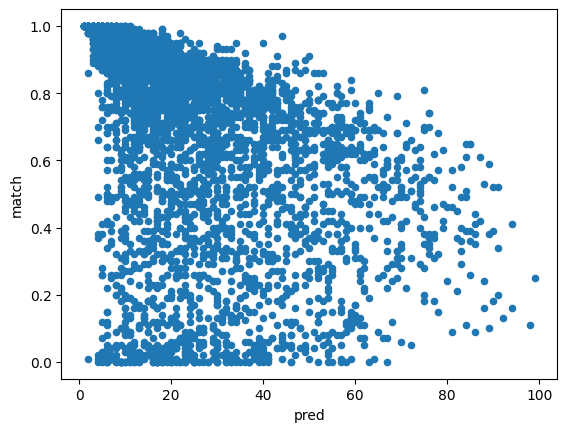

In [282]:
# number of matches vs number of unique preds per products
samples_from_7ck620_in_common.groupby('product').agg({'match':'mean', 'pred':'nunique'}).plot.scatter(x='pred', y='match');

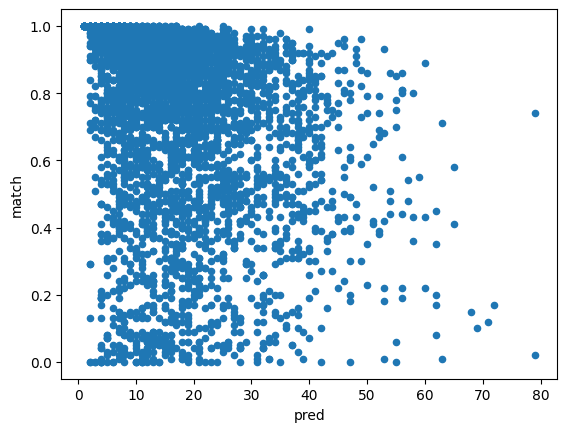

In [283]:
# number of matches vs number of unique preds per products
samples_from_rb_in_common.groupby('product').agg({'match':'mean', 'pred':'nunique'}).plot.scatter(x='pred', y='match');

In [ ]:
# reconstruct prediction in 7ck620

In [ ]:
# get count of unique samples per product => histogram per product, or for the same product in all files
# be careful with canonicalization etc

In [ ]:
# isolate data with exceptionally low unique sample counts/bad round_trip match numbers
